In [8]:
import pandas as pd
import numpy as np
from EM_mult import EM_mult
from group_opt import optimze_age_groups_v2, new_group_matrix, bootstrap
import pickle
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [9]:
electors = pd.read_csv('2021_11_Presidencial/output/2021_11_Presidencial_ELECTORES.csv')
votes = pd.read_csv('2021_11_Presidencial/output/2021_11_Presidencial_VOTOS.csv')
# READ PICKLE
with open('2021_11_Presidencial/output/GRUPOS.pickle', 'rb') as handle:
    grupos = pickle.load(handle)

with open('2021_11_Presidencial/output/CANDIDATOS.pickle', 'rb') as handle:
    candidatos = pickle.load(handle)
llave_mesa = ['CIRCUNSCRIPCION ELECTORAL', 'MESA']
df = votes.merge(electors[llave_mesa + grupos], on = llave_mesa, how = 'inner')    
 
# circs = electors['CIRCUNSCRIPCION ELECTORAL'].unique()

In [13]:
electors[['CIRCUNSCRIPCION ELECTORAL', 'LOCAL']].drop_duplicates().shape

(2808, 2)

In [10]:
# # SOME STATS
# votes[candidatos].sum().sum()

# e = electors['CIRCUNSCRIPCION ELECTORAL'].unique()
# v = votes['CIRCUNSCRIPCION ELECTORAL'].unique()
# # append e and v
# circs = np.append(e, v)
# len(np.unique(circs))

# votes[['CIRCUNSCRIPCION ELECTORAL', 'MESA']].drop_duplicates().shape

(46639, 2)

In [4]:
np.random.seed(123)
# count how many rows each "CIRCUNSCRIPCION ELECTORAL" has
num_mesas = votes.groupby('CIRCUNSCRIPCION ELECTORAL').count()['MESA']
rango_mesas = [[3,5],[10,20],[50,60],[100,150],[200,250],[500,550]]
circs = []
for m in rango_mesas:
    circ_m = num_mesas[(num_mesas >= m[0] ) & (num_mesas <= m[1])] 
    # choose random index
    idx = np.random.choice(circ_m.index)
    circs.append(idx)


In [6]:
# mus = [0.00005 ,0.0001, 0.00025, 0.0005, 0.001]
# corrs = [0.1, 0.2, 0.3, 0.4, 0.5]
# gamma = [0.2]

ll = {}

for circ in circs:

    x = df.loc[df['CIRCUNSCRIPCION ELECTORAL'] == circ, candidatos].values
    b = df.loc[df['CIRCUNSCRIPCION ELECTORAL'] == circ, grupos].values
    M = x.shape[0]
    print(circ,  f'({M})')


    group_combinations = {}
    group_combinations['1 Group'] = [[0,1,2,3,4,5,6,7]]
    group_combinations['2 Groups'] = [[0,1,2,3],[4,5,6,7]]
    group_combinations['3 Groups'] = [[0,1],[2,3],[4,5,6,7]]
    group_combinations['MIP'] = optimze_age_groups_v2(b, age_groups = 8, min_std = 0.001, max_corr = 0.5)
    group_combinations['4 Groups'] = [[i,i+1] for i in [0,2,4,6]]
    group_combinations['8 Groups'] = [[i] for i in range(8)]
    print(group_combinations['MIP'])
    # print(x.sum(axis = 0)/x.sum())
    print('-'*50)



    for key, values in group_combinations.items():
        b_new, _ = new_group_matrix(b, group_combinations[key])
        results = {}
        em = EM_mult(x, b_new, max_iterations=100000, convergence_value=0.00001, dict_results = results, verbose = False, load_bar =False)
        

        if key == '1 Group':
            agg_x = x.sum(axis = 0)
            p_est = agg_x/agg_x.sum()
      
            # compute the log-pmf of a multinomial random variable
            ll = np.sum(agg_x * np.log(p_est)) + np.sum([np.log(i) for i in range(1,agg_x.sum()+1)]) - np.sum([np.sum([np.log(i) for i in range(1,j+1)]) for j in agg_x])
            # print(ll)
            # print(results['E_log_q'])
            # print(ll)
            # print(p_est)

        print(key)
        print('ll:     \t',(results['Q'] - results['E_log_q'])/M)
        print('Q :     \t',results['Q'])
        print('E_log_q: \t',results['E_log_q'])
        # print(np.round(results['p_est'], 3))
        print('-'*50)
    print('-'*50)


OLMOPULLI (4)
--------------------------------------------------
-17.672572879279187
-698.539970857086
1 Group
ll:     	 -3.076661115917318
Q :     	 -710.8466153207553
E_log_q: 	 -698.539970857086
--------------------------------------------------
--------------------------------------------------
CHUQUICAMATA (16)
--------------------------------------------------
-25.23491504577578
-4315.949526286872
1 Group
ll:     	 -5.710508796456679
Q :     	 -4407.317667030179
E_log_q: 	 -4315.949526286872
--------------------------------------------------
--------------------------------------------------
PEDRO DE VALDIVIA (TEMUCO) (58)
--------------------------------------------------
-30.14159418478812
-14488.174726455023
1 Group
ll:     	 -7.705236648195814
Q :     	 -14935.07845205038
E_log_q: 	 -14488.174726455023
--------------------------------------------------
--------------------------------------------------
PAINE (126)
--------------------------------------------------
-33.6257952

# Bootstrap

In [ ]:
# mus = [0.00005 ,0.0001, 0.00025, 0.0005, 0.001]
# corrs = [0.1, 0.2, 0.3, 0.4, 0.5]
# gamma = [0.2]

ll = {}

for circ in circs:

    x = df.loc[df['CIRCUNSCRIPCION ELECTORAL'] == circ, candidatos].values
    b = df.loc[df['CIRCUNSCRIPCION ELECTORAL'] == circ, grupos].values
    print(circ,  f'({x.shape[0]})')


    group_combinations = {}
    group_combinations['1 Group'] = [[0,1,2,3,4,5,6,7]]
    group_combinations['2 Groups'] = [[0,1,2,3],[4,5,6,7]]
    group_combinations['3 Groups'] = [[0,1],[2,3],[4,5,6,7]]
    group_combinations['4 Groups'] = [[i,i+1] for i in [0,2,4,6]]
    group_combinations['8 Groups'] = [[i] for i in range(8)]
    # print(x.sum(axis = 0)/x.sum())
    print('-'*50)


    for key, values in group_combinations.items():
        b_new, _ = new_group_matrix(b, group_combinations[key])
        results = {}
        p_bootstrap = bootstrap(x, b_new, seed = 123)
        # if key == '8 Groups':
        #     # print index where p_bootstrap has nans
        #     print('p', p_bootstrap[16])

        #     # print(p_bootstrap)
        #     print('std',np.std(p_bootstrap, axis = 0))
        p_std = np.mean(np.std(p_bootstrap, axis = 0))
        print(key, f'{p_std}')

        # print(np.round(results['p_est'], 3))
        print('-'*50)
    print('-'*50)


# Optimize


In [4]:
np.random.seed(123)
# count how many rows each "CIRCUNSCRIPCION ELECTORAL" has
num_mesas = votes.groupby('CIRCUNSCRIPCION ELECTORAL').count()['MESA']
rango_mesas = [[3,10],[10,50],[50,100],[100,200],[200,300],[400,600]]
S_mesas = 5
circs = []
for m in rango_mesas:
    circ_m = num_mesas[(num_mesas >= m[0] ) & (num_mesas <= m[1])] 
    # choose random index
    idx = np.random.choice(circ_m.index, size = S_mesas, replace = False)
    circs += list(idx)


In [10]:

# MIP_df.to_csv('MIP_df_v2.csv')
MIP_df = pd.read_csv('MIP_df_v4.csv')
MIP_df['ll-M'] = MIP_df['ll']/MIP_df['M']

In [ ]:
# import seaborn as sns
# import matplotlib.pyplot as plt
# circ = 'CALLE LARGA'
# x = df.loc[df['CIRCUNSCRIPCION ELECTORAL'] == circ, candidatos].values
# b = df.loc[df['CIRCUNSCRIPCION ELECTORAL'] == circ, grupos].values
# group_combinations = optimze_age_groups(b, age_groups = 8, min_std = 0.075, max_corr = 0.8)
# b_new, _ = new_group_matrix(b, group_combinations) 
# print(group_combinations)
# sns.heatmap(b/np.sum(b, axis = 1)[:, None])
# plt.show()
# sns.heatmap(b_new/np.sum(b_new, axis = 1)[:, None])
# plt.show()

In [ ]:

mean_params = MIP_df[['min_std', 'max_corr', 'll-M', 'p_std', 'tie']].groupby(['min_std', 'max_corr', 'tie']).mean()
max_params = MIP_df[['min_std', 'max_corr', 'll-M', 'p_std', 'tie']].groupby(['min_std', 'max_corr', 'tie']).max()
# mean_params = mean_params[max_params['p_std'] <= 0.02]
mean_params = mean_params[mean_params['p_std'] <= 0.05]
# display(mean_params)
# get the best combination for ll-M
best_std, best_corr, best_tie = mean_params[mean_params['ll-M'] == mean_params['ll-M'].max()].index[0]

MIP_df[(MIP_df['min_std'] == best_std) & (MIP_df['max_corr'] == best_corr) & (MIP_df['tie'] == best_tie)]

In [5]:
# import seaborn as sns
# import matplotlib.pyplot as plt

# # do subplots
# fig, ax = plt.subplots(1, 1, figsize=(11,6))


# for i, circ in enumerate(circs):
#     MIP_circ = MIP_df[(MIP_df['Circunscripcion'] == circ) & (MIP_df['max_corr'].isin([.8, 1]))& (MIP_df['min_std'] == 0.1)]
#     # display(MIP_circ)
#     M = 5000/MIP_circ['M'].unique()
#     # size = MIP_circ['min_std'].values*200
#     # sns.scatterplot(data = MIP_circ, x='ll-M', y='p_std', hue='max_corr', s=20, legend = i == 0, ax = ax[0], palette = 'Set1')
#     sns.scatterplot(data = MIP_circ, x='ll-M', y='p_std', hue='min_std', s=M, legend = i == 0, ax = ax, 
#     palette = 'Set1', style = 'max_corr')
# plt.show()
#     # display(MIP_circ.loc[[MIP_circ['ll'].idxmax()]])

# Probabilities 

EL GOLF
SALTOS DEL LAJA


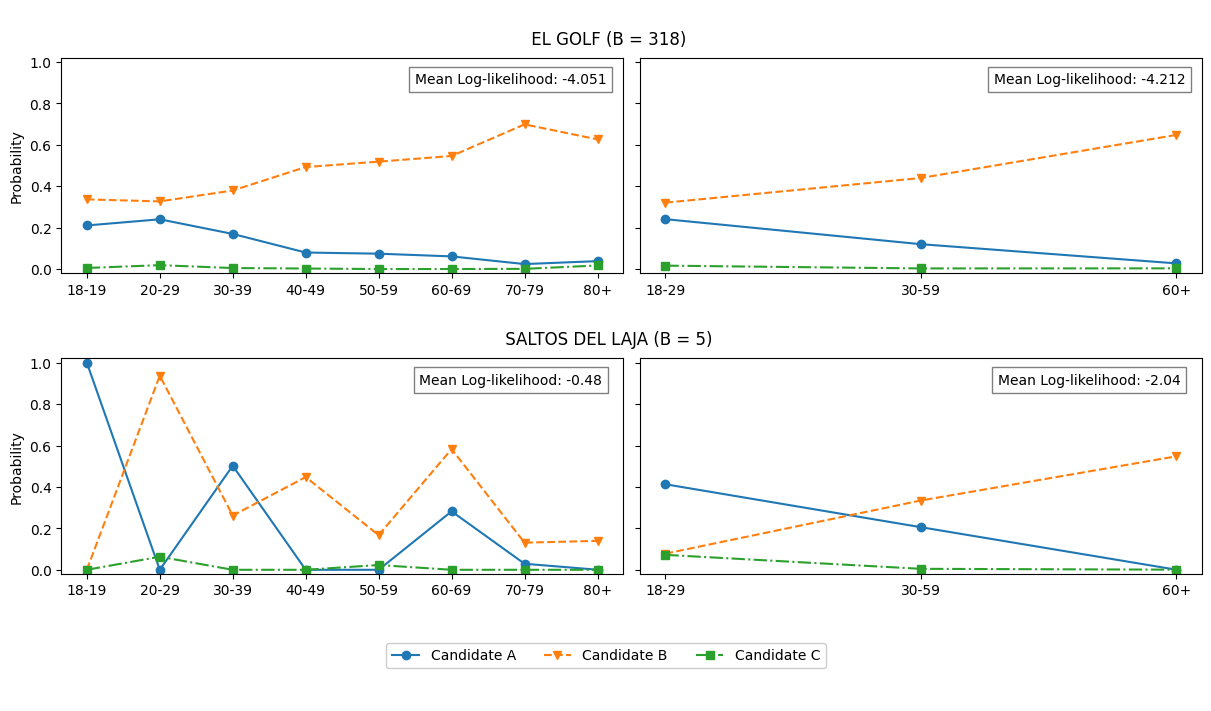

In [3]:
import matplotlib.pyplot as plt


# count how many rows each "CIRCUNSCRIPCION ELECTORAL" has
num_mesas = votes.groupby('CIRCUNSCRIPCION ELECTORAL').count()['MESA']
# circ_m = num_mesas[(num_mesas >= 20 ) & (num_mesas <= 40)]
# small_circ = np.random.choice(circ_m.index, size = S_mesas, replace = False)[0]
# circs = ['EL GOLF', small_circ]
circs = ['EL GOLF', 'SALTOS DEL LAJA']
# circs = ['EL GOLF', 'MARCHIGUE']

group_combinations_list = [[[0],[1],[2],[3],[4],[5],[6],[7]],
                             [[0,1],[2,3,4],[5,6,7]]]

prob_df = []

candidates_used = [2,3,5]

fig = plt.figure(constrained_layout=True, figsize=(12, 7))
# fig.suptitle('Figure title')
subfigs = fig.subfigures(nrows = 3, ncols = 1, height_ratios = [3,3,1])

# Create subplots

candidate_label = ['Candidate A', 'Candidate B', 'Candidate C']

# list of 3 markers
markers = ['o', 'v', 's']
# list of 3 linestyles
linestyles = ['-', '--', '-.']


for i, circ in enumerate(circs):
    # opt_ll = -np.inf
    x = df.loc[df['CIRCUNSCRIPCION ELECTORAL'] == circ, candidatos].values
    b = df.loc[df['CIRCUNSCRIPCION ELECTORAL'] == circ, grupos].values
    M = len(x)
    subfigs[i].suptitle(f'\n {circ} (B = {M})')
    axs = subfigs[i].subplots(nrows=1, ncols=2, sharey = True)
    print(circ)
    for j, group_combinations in enumerate(group_combinations_list):
    # group_combinations = optimze_age_groups(b, age_groups = 8, min_std = min_std, max_corr = max_corr)
        b_new, group_names = new_group_matrix(b, group_combinations) 
        results = {}
        em = EM_mult(x, b_new, max_iterations = 10000, dict_results = results, verbose = False, load_bar =False)
        ll = (results['Q'] - results['E_log_q'])/M
        p_est = results['p_est']
        prob_df.append([circ, M, group_combinations, ll, p_est])
        for c_ix, c in enumerate(candidates_used):
            # plot with markers
            axs[j].plot(p_est[:,c], label = candidate_label[c_ix], 
                        marker = markers[c_ix], linestyle = linestyles[c_ix])
        # set ticks for axis
        axs[j].set_xticks(range(len(group_names)), group_names)

        # add ll to plot
        # axs[j].text(0.5, 0.9, f'Mean Log-likelihood: {np.round(ll, 3)}',
        #  horizontalalignment='center', verticalalignment='center', transform=axs[j].transAxes)

        # add ll to plot
        axs[j].text(0.8, 0.9, f'Mean Log-likelihood: {np.round(ll, 3)}',
         horizontalalignment='center', verticalalignment='center', transform=axs[j].transAxes,
         bbox=dict(facecolor='white', alpha=0.5))

        axs[0].set_ylim([-0.02,1.02])
        # name of y axis
        if j == 0:
            axs[j].set_ylabel('Probability')

        # if i == 1 and j == 0:
        #     axs[j].legend(loc = (0.3,-0.8))
axs_label = subfigs[2].subplots(nrows=1, ncols=1)
for c_ix, c in enumerate(candidates_used):
    axs_label.plot([0,0],[0,0], label = candidate_label[c_ix], 
                   marker = markers[c_ix], linestyle = linestyles[c_ix])
axs_label.set_frame_on(False)
axs_label.xaxis.set_visible(False)
axs_label.yaxis.set_visible(False)
axs_label.legend(loc = 'center', ncol = 3)
legend = axs_label.legend(loc = 'center', ncol = 3) 
legend.get_frame().set_alpha(1)
# save figure

# set hspace
# fig.subplots_adjust(hspace=0.3, wspace = 0.1)

plt.savefig('images/elections/probabilities.pdf', bbox_inches='tight')




# axs_label.legend()
# axs_label.gca().xaxis.set_major_locator(plt.NullLocator())
# axs_label.gca().yaxis.set_major_locator(plt.NullLocator())
# axs_label.plot(np.NaN, np.NaN, '-', color='none', label='')
        # if i == 0 and j == 0:
        #   axs[j].legend(loc = 'upper left')
        #   axs[j].legend(loc = (-0.5,1))
# plt.legend(loc = ())

# fig.subplots_adjust(top=0.9, left=0.1, right=0.9, bottom=0.12)  # create some space below the plots by increasing the bottom-value
    # axs.flatten()[-2].legend(loc='upper center', bbox_to_anchor=(0.5, -0.12), ncol=3)



## Presentación

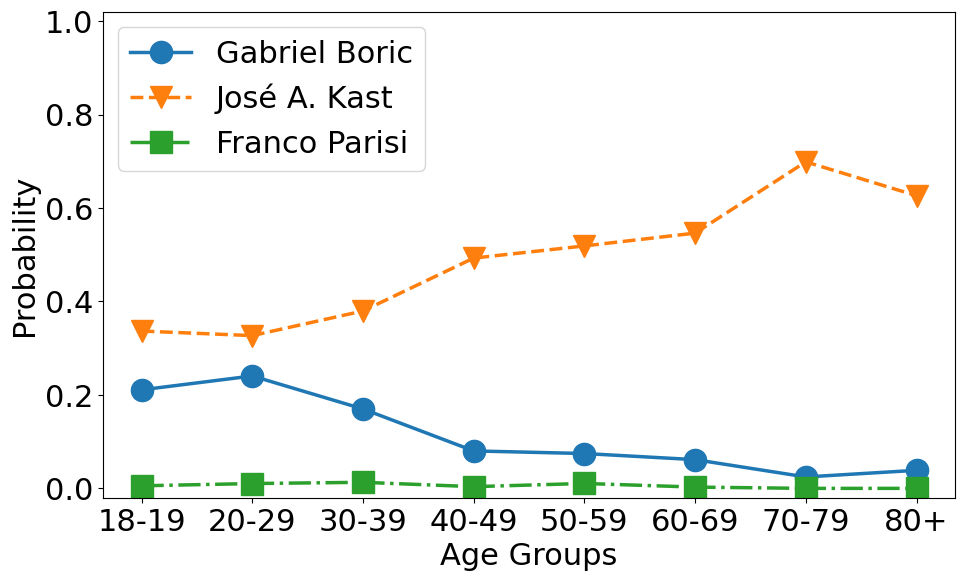

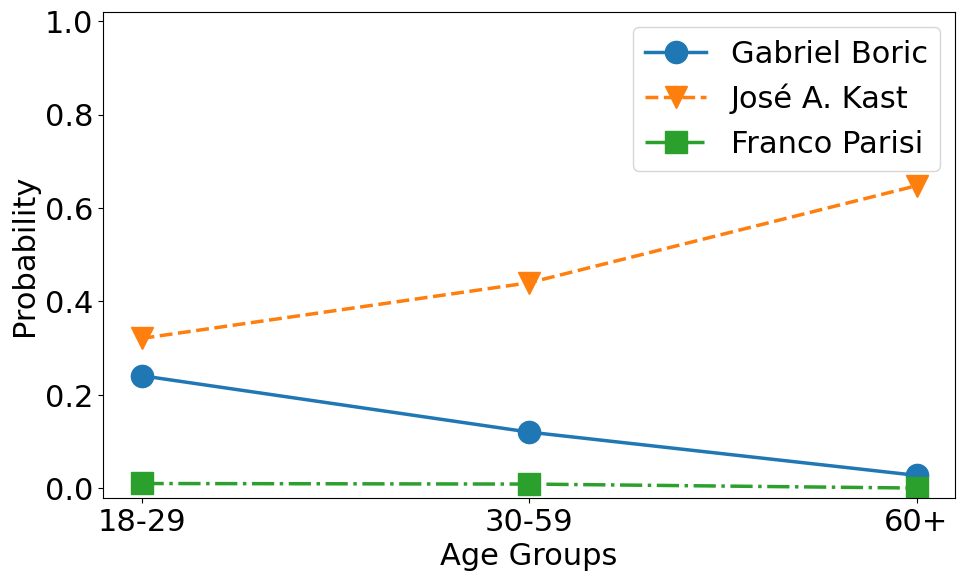

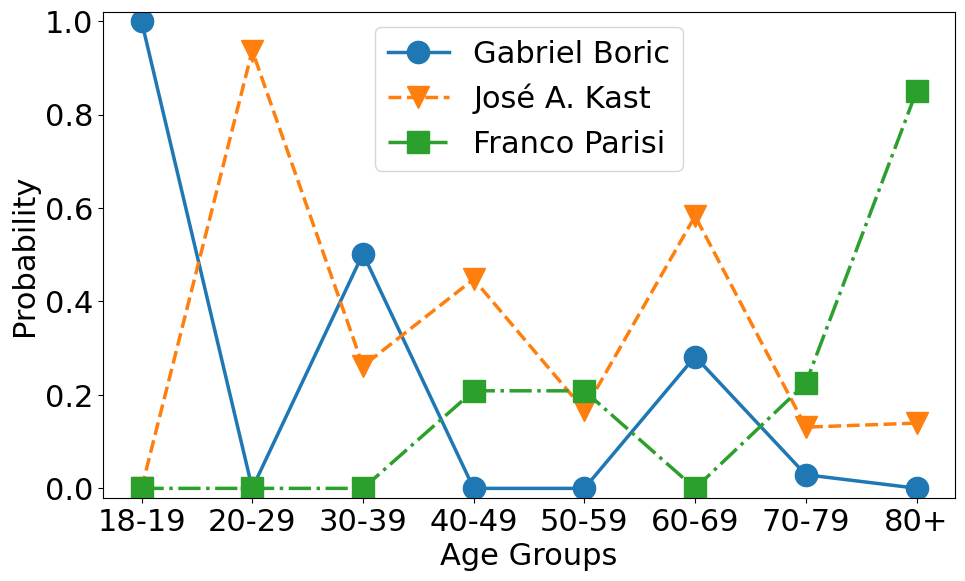

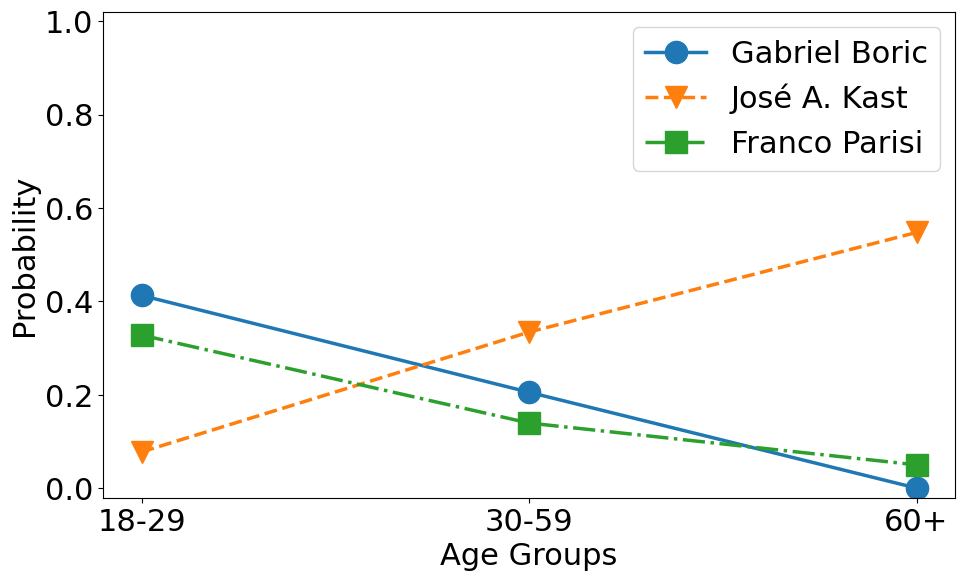

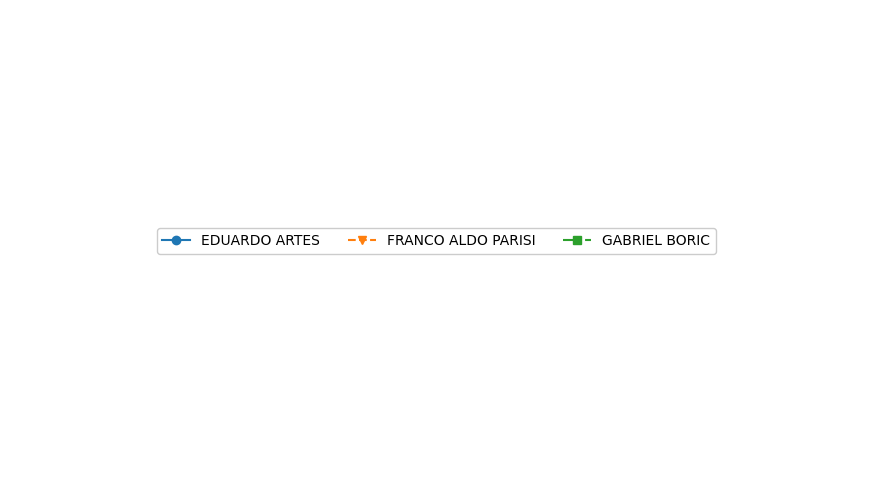

In [60]:
import matplotlib.pyplot as plt


# count how many rows each "CIRCUNSCRIPCION ELECTORAL" has
num_mesas = votes.groupby('CIRCUNSCRIPCION ELECTORAL').count()['MESA']
# circ_m = num_mesas[(num_mesas >= 20 ) & (num_mesas <= 40)]
# small_circ = np.random.choice(circ_m.index, size = S_mesas, replace = False)[0]
# circs = ['EL GOLF', small_circ]
circs = ['EL GOLF', 'SALTOS DEL LAJA']
# circs = ['EL GOLF', 'MARCHIGUE']

group_combinations_list = [[[0],[1],[2],[3],[4],[5],[6],[7]],
                             [[0,1],[2,3,4],[5,6,7]]]

prob_df = []

candidates_used = [2,3,1]

candidate_labels = ['Gabriel Boric', 'José A. Kast', 'Franco Parisi']

# fig = plt.figure(constrained_layout=True, figsize=(12, 6))
# fig.suptitle('Figure title')
# subfigs = fig.subfigures(nrows = 3, ncols = 1, height_ratios = [3,3,1])

# Create subplots

# candidate_label = ['Candidate A', 'Candidate B', 'Candidate C']

# list of 3 markers
markers = ['o', 'v', 's']
# list of 3 linestyles
linestyles = ['-', '--', '-.']

add_leg = True
leg = 'legend'

for i, circ in enumerate(circs):
    
    # opt_ll = -np.inf
    x = df.loc[df['CIRCUNSCRIPCION ELECTORAL'] == circ, candidatos].values
    b = df.loc[df['CIRCUNSCRIPCION ELECTORAL'] == circ, grupos].values
    M = len(x)

    for j, group_combinations in enumerate(group_combinations_list):
        fig, ax = plt.subplots(1, 1, figsize=(11,6))
        # fig.suptitle(f'{circ} (B = {M})')
        # reduce space from title
        fig.subplots_adjust(top=0.92)
    # group_combinations = optimze_age_groups(b, age_groups = 8, min_std = min_std, max_corr = max_corr)
        b_new, group_names = new_group_matrix(b, group_combinations) 
        results = {}
        em = EM_mult(x, b_new, max_iterations = 10000, dict_results = results, verbose = False, load_bar =False)
        ll = (results['Q'] - results['E_log_q'])/M
        p_est = results['p_est']
        prob_df.append([circ, M, group_combinations, ll, p_est])
        for c_ix, c in enumerate(candidates_used):
            # plot with markers
            ax.plot(p_est[:,c], label = candidate_labels[c_ix], 
                        marker = markers[c_ix], linestyle = linestyles[c_ix],
                        linewidth = 2.5, markersize = 16)
        # Create empty plot with blank marker containing the extra label
        # ax.plot([], [], ' ', label=f'Mean Log-likelihood: {np.round(ll, 3)}')
        if add_leg:
            ax.legend(loc = 'best', fontsize = 22) 
            # add text to legend
        # set ticks for axis
        ax.set_xticks(range(len(group_names)), group_names)

        # add ll to plot
        # ax.text(0.8, 0.9, f'Mean Log-likelihood: {np.round(ll, 3)}',
        #  horizontalalignment='center', verticalalignment='center', transform=ax.transAxes,
        #  bbox=dict(facecolor='white', alpha=0.5))

        ax.set_ylim([-0.02,1.02])

        ax.set_ylabel('Probability', fontsize = 22)
        # set x label
        ax.set_xlabel('Age Groups', fontsize = 22)
        # save fig
        # ticks fontsize
        ax.tick_params(axis='both', which='major', labelsize=22)
        # fontsize for everything
        # plt.rcParams.update({'font.size': 18})

        plt.savefig(f'images/presentacion/probs/{circ}_{j}_{add_leg*leg}.pdf', bbox_inches='tight')

        # fig.show()
        # if i == 1 and j == 0:
        #     axs[j].legend(loc = (0.3,-0.8))
fig, axs_label = plt.subplots(1, 1, figsize=(11,6))
for c_ix, c in enumerate(candidates_used):
    axs_label.plot([0,0],[0,0], label = candidatos[c_ix], 
                   marker = markers[c_ix], linestyle = linestyles[c_ix])
axs_label.set_frame_on(False)
axs_label.xaxis.set_visible(False)
axs_label.yaxis.set_visible(False)
legend = axs_label.legend(loc = 'center', ncol = 3) 
legend.get_frame().set_alpha(1)
# legend.get_frame().set_facecolor((0, 0, 0.1, 0.1))
# fig.show()
# save fig tight
plt.savefig(f'images/presentacion/probs/legend_probs.pdf', bbox_inches='tight')
# save figure
# plt.savefig('images/elections/probabilities.pdf', bbox_inches='tight')


# go back to default font size
# plt.rcParams.update({'font.size': 10})

# axs_label.legend()
# axs_label.gca().xaxis.set_major_locator(plt.NullLocator())
# axs_label.gca().yaxis.set_major_locator(plt.NullLocator())
# axs_label.plot(np.NaN, np.NaN, '-', color='none', label='')
        # if i == 0 and j == 0:
        #   axs[j].legend(loc = 'upper left')
        #   axs[j].legend(loc = (-0.5,1))
# plt.legend(loc = ())

# fig.subplots_adjust(top=0.9, left=0.1, right=0.9, bottom=0.12)  # create some space below the plots by increasing the bottom-value
    # axs.flatten()[-2].legend(loc='upper center', bbox_to_anchor=(0.5, -0.12), ncol=3)



# Different Approach

## 6 ranges


In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

np.random.seed(12)
# count how many rows each "CIRCUNSCRIPCION ELECTORAL" has
num_mesas = votes.groupby('CIRCUNSCRIPCION ELECTORAL').count()['MESA']
# rango_mesas = [[0,10],[1,50],[50,100],[100,200],[200,300],[400,600]]
# S_mesas = 5
# rango_mesas = [[1,10],[20,25],[60,70],[130,140],[300,320],[500,600]]
rango_mesas = [[4,8],[80,110],[400,600]]
S_mesas = 1
circs = []
for m in rango_mesas:
    circ_m = num_mesas[(num_mesas >= m[0] ) & (num_mesas <= m[1])] 
    # choose random index
    idx = np.random.choice(circ_m.index, size = S_mesas, replace = False)[0]
    circs.append(idx)

circs = ['CANCURA', 'EL BELLOTO', 'PROVIDENCIA']

group_combinations_list = [[[0,1,2,3,4,5,6,7]],
                      [[0,1,2,3],[4,5,6,7]],
                      [[0,1],[2,3],[4,5],[6,7]],
                      [[0,1],[2],[3],[4],[5],[6,7]],
                      [[0],[1],[2],[3],[4],[5],[6],[7]]]

# group_combinations_list = [[[0,1,2,3,4,5,6,7]],
#                       [[0,1,2,3],[4,5,6,7]],
#                         [[0,1,2],[3,4],[5,6,7]],
#                       [[0,1],[2,3],[4,5],[6,7]],
#                       [[0],[1],[2,3],[4,5],[6,7]],
#                       [[0],[1],[2],[3],[4,5],[6,7]],
#                       [[0],[1],[2],[3],[4],[5],[6,7]],
#                       [[0],[1],[2],[3],[4],[5],[6],[7]],
#                       [[0],[1],[2],[3],[4],[5],[6],[7]]]

GROUP_df = []

for circ in circs:
    print(circ)
    opt_ll = -np.inf
    x = df.loc[df['CIRCUNSCRIPCION ELECTORAL'] == circ, candidatos].values
    b = df.loc[df['CIRCUNSCRIPCION ELECTORAL'] == circ, grupos].values
    M = len(x)
    # iterate backwards group_cobinations_list
    below_thres = False
    for group_combinations in group_combinations_list[::-1]:
    # group_combinations = optimze_age_groups(b, age_groups = 8, min_std = min_std, max_corr = max_corr)
        b_new, _ = new_group_matrix(b, group_combinations) 
        results = {}
        em = EM_mult(x, b_new, max_iterations = 10000, dict_results = results, verbose = False, load_bar =False)
        ll = results['Q'] - results['E_log_q']
        p_bootstrap = bootstrap(x, b_new, S = 20, seed = 123)
        p_std = np.max(np.std(p_bootstrap, axis = 0))
        if not below_thres:
            if p_std <= 0.05:
                below_thres = True
                GROUP_df.append([circ, M, group_combinations, ll, p_std, 1])
        GROUP_df.append([circ, M, group_combinations, ll, p_std, 0])

GROUP_df = pd.DataFrame(GROUP_df, columns = ['Circunscripcion', 'M', 'group_combinations', 'll', 'p_std', 'alphas'])

GROUP_df['G'] = GROUP_df['group_combinations'].apply(len)
GROUP_df['ll-M'] = GROUP_df['ll']/GROUP_df['M']
# rango_mesas = [[3,10],[10,50],[50,100],[100,200],[200,300],[400,600]]
GROUP_df['Circunscripcion-M'] = GROUP_df['Circunscripcion'] + ' ' + GROUP_df['M'].astype(str)

CANCURA
EL BELLOTO
PROVIDENCIA


C:\Users\pablo\AppData\Local\Temp\ipykernel_21796\1278616293.py:24: UserWarning: The palette list has more values (3) than needed (1), which may not be intended.
  ax = sns.scatterplot(data = GROUP_df_sub, x='ll-M', y='p_std',
C:\Users\pablo\AppData\Local\Temp\ipykernel_21796\1278616293.py:24: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  ax = sns.scatterplot(data = GROUP_df_sub, x='ll-M', y='p_std',
C:\Users\pablo\AppData\Local\Temp\ipykernel_21796\1278616293.py:75: UserWarning: The sizes list has more values (5) than needed (3), which may not be intended.
  sns.scatterplot(data = GROUP_df_show, x='ll-M', y='p_std',


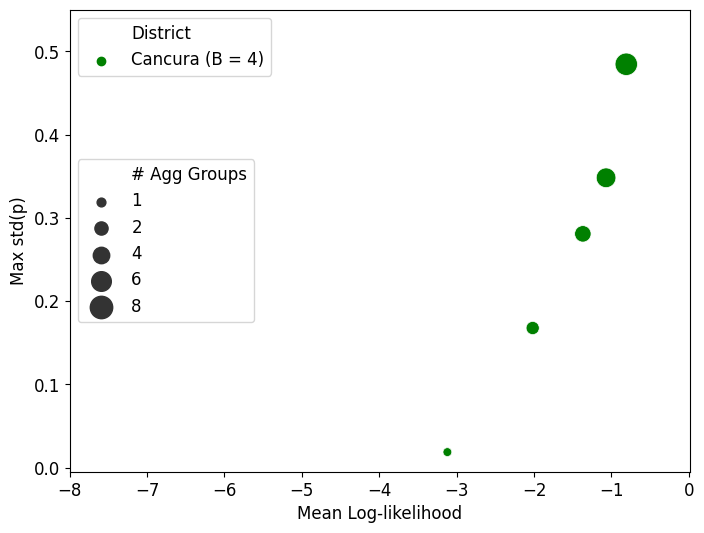

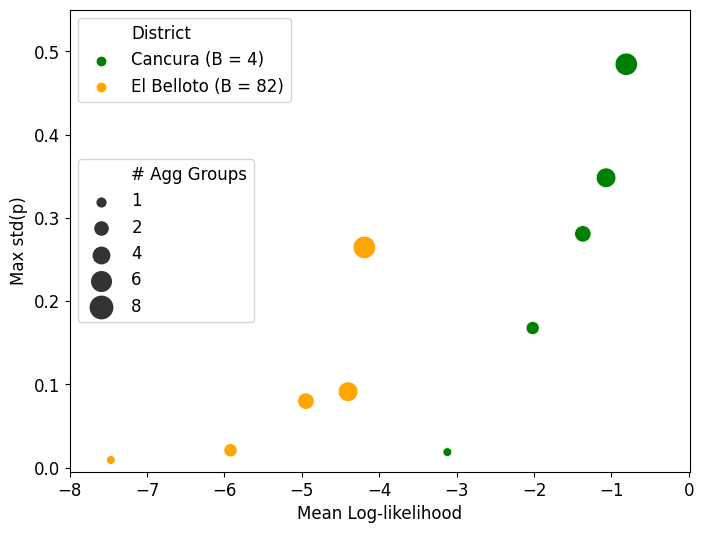

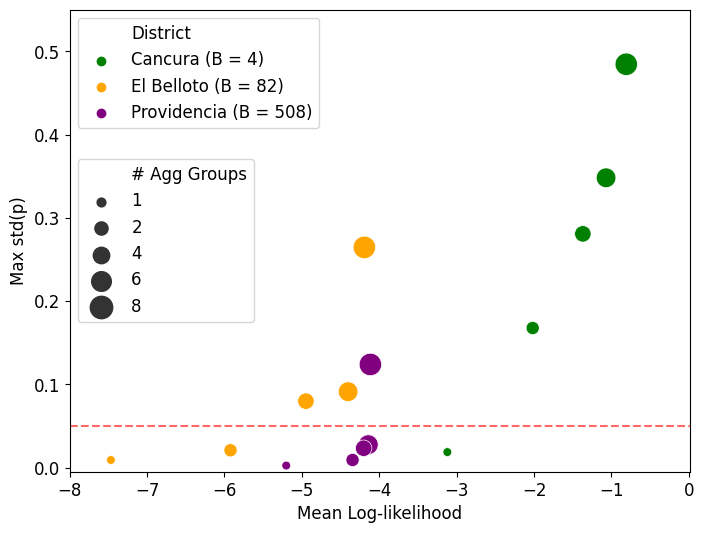

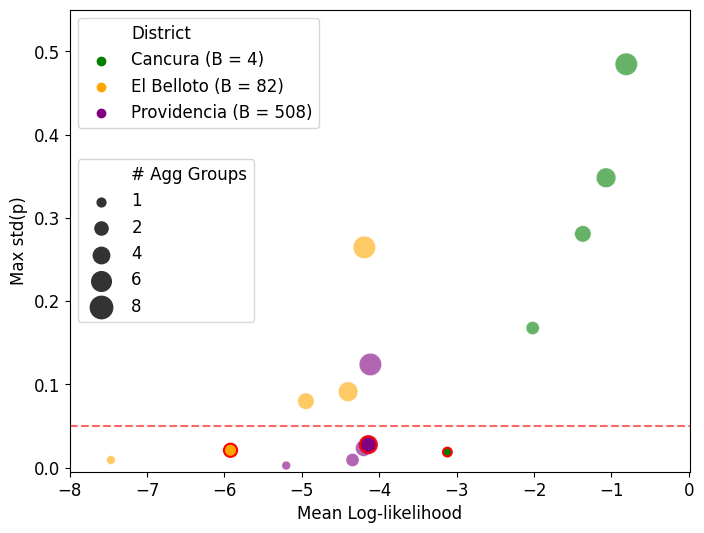

In [7]:
# figure_list = ['o', '+', '^', 's']
figure_list = [',', 'v', 'o', 'X']
# display(GROUP_df)
GROUP_df['District'] = GROUP_df['Circunscripcion'].apply(lambda x: x.title())  #.apply(lambda x: x.split(' ')[0])
GROUP_df['District'] = GROUP_df['District'].astype(str) + ' (B = ' + GROUP_df['M'].astype(str) +')'
# astype categorical
# GROUP_df['District'] = pd.Categorical(GROUP_df['District'], categories = GROUP_df['District'].unique(), ordered = True)

# GROUP_df['Number of Groups'] = GROUP_df['G'].astype(str) + ' Groups'
GROUP_df['# Agg Groups'] = GROUP_df['G']

colors = ['green', 'orange', 'purple']
size_list = [40, 90, 140, 200, 260]

for cix in range(len(circs)):

    sub_circs = circs[:cix+1]
    GROUP_df_sub = GROUP_df[GROUP_df['Circunscripcion'].isin(sub_circs)]
    
    # display(GROUP_df_sub)
    #choose fig size
    fig, ax = plt.subplots(1, 1, figsize=(8,6))

    ax = sns.scatterplot(data = GROUP_df_sub, x='ll-M', y='p_std',
        hue='District', size='# Agg Groups', sizes = size_list, legend = True, palette = colors,
        markers = figure_list)

    # horizontal dotted line for max of each point

    # x axis name
    ax.set_xlabel('Mean Log-likelihood', fontsize = 12)
    # y axis name
    ax.set_ylabel('Max std(p)', fontsize = 12)

    # ax limits
    ax.set_ylim([-0.005,0.55])
    ax.set_xlim([-8,0.01])

    # ticks fontsize
    ax.tick_params(axis='both', which='major', labelsize=12)

    h,l = ax.get_legend_handles_labels()
    l1 = ax.legend(h[:cix+2],l[:cix+2], loc='upper left', fontsize = 12)
    l2 = ax.legend(h[cix+2:],l[cix+2:], loc='center left', fontsize = 12)
    ax.add_artist(l1) 

    # get max p_std for each circ
    max_p_std = GROUP_df_sub.groupby('Circunscripcion')['p_std'].max().values
    # for each one draw a horizontal line
    # for i, p in enumerate(max_p_std):
    #     ax.axhline(y=p, xmin=0, xmax=1, linestyle='--', color = colors[i], alpha = 0.5)

    # save fig
    plt.savefig(f'images/presentacion/ll_std_{cix}.pdf', bbox_inches='tight')
        # add text to line
        # ax.text(0.01, p, f'{np.round(p, 3)}', fontsize = 12, verticalalignment='center')
    if cix == 2:
        # add dotted line in 0.05
        ax.axhline(y=0.05, xmin=0, xmax=1, linestyle='--', color = 'red', alpha = 0.6,
                   linewidth = 1.5)
        # save fig
        plt.savefig(f'images/presentacion/ll_std_{cix+1}.pdf', bbox_inches='tight')
# FINAL PLOT

fig, ax = plt.subplots(1, 1, figsize=(8,6))

# df of alpha = 0
GROUP_df_noshow = GROUP_df[GROUP_df['alphas'] == 0]
ax = sns.scatterplot(data = GROUP_df_noshow, x='ll-M', y='p_std',
    hue='District', size='# Agg Groups', sizes = size_list, legend = True, palette = colors,
    markers = figure_list, alpha = 0.6, ax = ax)

# df of alpha = 1
GROUP_df_show = GROUP_df[GROUP_df['alphas'] == 1]
sns.scatterplot(data = GROUP_df_show, x='ll-M', y='p_std',
    hue='District', size='# Agg Groups', sizes = size_list, legend = False, palette = colors,
    markers = figure_list, alpha = 1, ax = ax, edgecolor = 'red', linewidth = 1.5)



# horizontal dotted line for max of each point

# x axis name
ax.set_xlabel('Mean Log-likelihood', fontsize = 12)
# y axis name
ax.set_ylabel('Max std(p)', fontsize = 12)

# ax limits
ax.set_ylim([-0.005,0.55])
ax.set_xlim([-8,0.01])

# ticks fontsize
ax.tick_params(axis='both', which='major', labelsize=12)

h,l = ax.get_legend_handles_labels()
l1 = ax.legend(h[:cix+2],l[:cix+2], loc='upper left', fontsize = 12)
l2 = ax.legend(h[cix+2:],l[cix+2:], loc='center left', fontsize = 12)
ax.add_artist(l1) 

# add dotted line in 0.05
ax.axhline(y=0.05, xmin=0, xmax=1, linestyle='--', color = 'red', alpha = 0.6,
                   linewidth = 1.5)
# save fige
plt.savefig(f'images/presentacion/ll_std_4.pdf', bbox_inches='tight')

## Other try (indepenedent graph)

RIO NEGRO


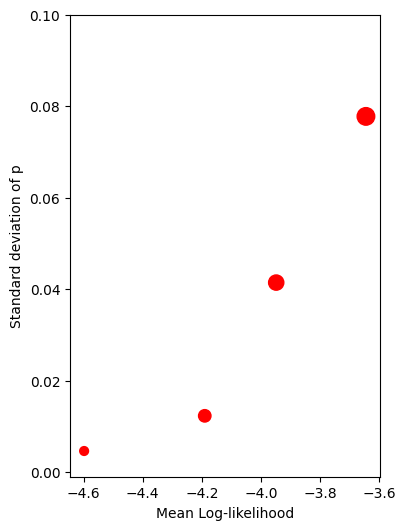

EL BELLOTO


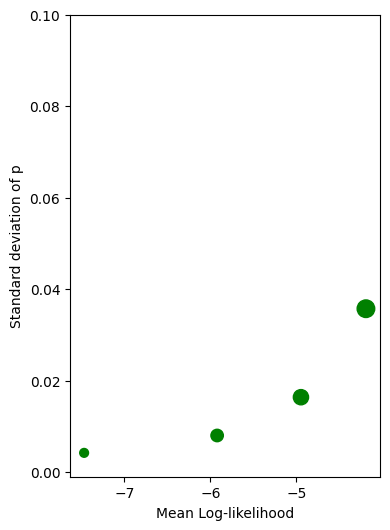

PROVIDENCIA


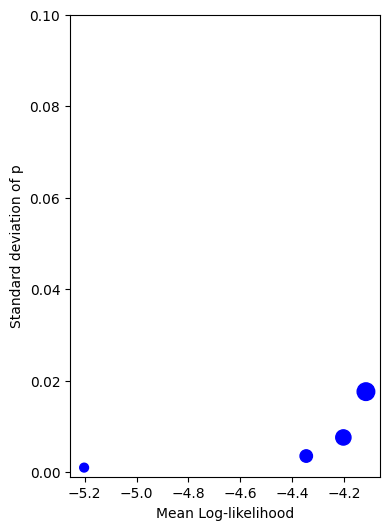

In [55]:
# import seaborn as sns
# import matplotlib.pyplot as plt

# np.random.seed(12)
# # count how many rows each "CIRCUNSCRIPCION ELECTORAL" has
# num_mesas = votes.groupby('CIRCUNSCRIPCION ELECTORAL').count()['MESA']
# # rango_mesas = [[0,10],[1,50],[50,100],[100,200],[200,300],[400,600]]
# # S_mesas = 5
# # rango_mesas = [[1,10],[20,25],[60,70],[130,140],[300,320],[500,600]]
# rango_mesas = [[4,8],[80,110],[400,600]]
# S_mesas = 1
# circs = []
# for m in rango_mesas:
#     circ_m = num_mesas[(num_mesas >= m[0] ) & (num_mesas <= m[1])] 
#     # choose random index
#     idx = np.random.choice(circ_m.index, size = S_mesas, replace = False)[0]
#     circs.append(idx)

# circs = ['RIO NEGRO', 'EL BELLOTO', 'PROVIDENCIA']

# group_combinations_list = [[[0,1,2,3,4,5,6,7]],
#                       [[0,1,2,3],[4,5,6,7]],
#                       [[0,1],[2,3],[4,5],[6,7]],
#                       [[0],[1],[2],[3],[4],[5],[6],[7]]]

# # group_combinations_list = [[[0,1,2,3,4,5,6,7]],
# #                       [[0,1,2,3],[4,5,6,7]],
# #                         [[0,1,2],[3,4],[5,6,7]],
# #                       [[0,1],[2,3],[4,5],[6,7]],
# #                       [[0],[1],[2,3],[4,5],[6,7]],
# #                       [[0],[1],[2],[3],[4,5],[6,7]],
# #                       [[0],[1],[2],[3],[4],[5],[6,7]],
# #                       [[0],[1],[2],[3],[4],[5],[6],[7]],
# #                       [[0],[1],[2],[3],[4],[5],[6],[7]]]

# GROUP_df = []

# color_list = ['red', 'green', 'blue']

# for ix, circ in enumerate(circs):
#     print(circ)
#     opt_ll = -np.inf
#     x = df.loc[df['CIRCUNSCRIPCION ELECTORAL'] == circ, candidatos].values
#     b = df.loc[df['CIRCUNSCRIPCION ELECTORAL'] == circ, grupos].values
#     M = len(x)
#     p_std_list = []
#     ll_list = []
#     for group_combinations in group_combinations_list:
#     # group_combinations = optimze_age_groups(b, age_groups = 8, min_std = min_std, max_corr = max_corr)
#         b_new, _ = new_group_matrix(b, group_combinations) 
#         results = {}
#         em = EM_mult(x, b_new, max_iterations = 10000, dict_results = results, verbose = False, load_bar =False)
#         ll = results['Q'] - results['E_log_q']
#         p_bootstrap = bootstrap(x, b_new, S = 20, seed = 123)
#         p_std = np.mean(np.std(p_bootstrap, axis = 0))
#         GROUP_df.append([circ, M, group_combinations, ll, p_std])
#         p_std_list.append(p_std)
#         ll_list.append(ll/M)
#     # scatter plot
#     fig, ax = plt.subplots(1, 1, figsize=(4,6))
#     ax.scatter(ll_list, p_std_list, s = [40,80,120,160], c = color_list[ix])
#     # y lim
#     ax.set_ylim([-0.001,0.1])
#     # axis names
#     ax.set_xlabel('Mean Log-likelihood')
#     ax.set_ylabel('Standard deviation of p')
#     plt.show()


# GROUP_df = pd.DataFrame(GROUP_df, columns = ['Circunscripcion', 'M', 'group_combinations', 'll', 'p_std'])

# GROUP_df['G'] = GROUP_df['group_combinations'].apply(len)
# GROUP_df['ll-M'] = GROUP_df['ll']/GROUP_df['M']
# # rango_mesas = [[3,10],[10,50],[50,100],[100,200],[200,300],[400,600]]
# GROUP_df['Circunscripcion-M'] = GROUP_df['Circunscripcion'] + ' ' + GROUP_df['M'].astype(str)

## 4 ranges


In [4]:
np.random.seed(123)
# count how many rows each "CIRCUNSCRIPCION ELECTORAL" has
num_mesas = votes.groupby('CIRCUNSCRIPCION ELECTORAL').count()['MESA']
# rango_mesas = [[0,10],[1,50],[50,100],[100,200],[200,300],[400,600]]
# S_mesas = 5
# rango_mesas = [[2,30],[31,100],[101,300],[301,600]]
rango_mesas = [[2,20],[50,100],[150,200],[450,500]]
S_mesas = 4
circs = []
for m in rango_mesas:
    circ_m = num_mesas[(num_mesas >= m[0] ) & (num_mesas <= m[1])] 
    # choose random index
    idx = np.random.choice(circ_m.index, size = S_mesas, replace = False)
    circs.append(list(idx))


In [5]:
group_combinations_list = [[[0,1,2,3,4,5,6,7]],
                      [[0,1,2,3],[4,5,6,7]],
                    #   [[0,1],[2,3],[4,5,6,7]],
                    #   [[0,1,2,3],[4,5],[6,7]],
                      [[0,1],[2,3],[4,5],[6,7]],
                      [[0],[1],[2],[3],[4],[5],[6],[7]]]


GROUP_df_2 = []

for circ_M in circs:
    for circ in circ_M:
        print(circ)
        opt_ll = -np.inf
        x = df.loc[df['CIRCUNSCRIPCION ELECTORAL'] == circ, candidatos].values
        b = df.loc[df['CIRCUNSCRIPCION ELECTORAL'] == circ, grupos].values
        M = len(x)
        for group_combinations in group_combinations_list:
        # group_combinations = optimze_age_groups(b, age_groups = 8, min_std = min_std, max_corr = max_corr)
            b_new, _ = new_group_matrix(b, group_combinations) 
            results = {}
            em = EM_mult(x, b_new, max_iterations = 10000, dict_results = results, verbose = False, load_bar =False)
            ll = results['Q'] - results['E_log_q']
            p_bootstrap = bootstrap(x, b_new, S = 20, seed = 123)
            p_std = np.mean(np.std(p_bootstrap, axis = 0))
            GROUP_df_2.append([circ, M, group_combinations, ll, p_std])

GROUP_df_2 = pd.DataFrame(GROUP_df_2, columns = ['Circunscripcion', 'M', 'group_combinations', 'll', 'p_std'])

RIACHUELO
BALMACEDA
CACHAPOAL
HUALAIHUE PUERTO
MOSTAZAL
CURACAUTIN
LOS CERROS
BULNES
PADRE LAS CASAS
EL CORTIJO
PLAZA EGANA
ESTADIO NACIONAL
APOQUINDO
IQUIQUE
CONCEPCION CENTRO
EL PUERTO


In [ ]:
# import matplotlib.pyplot as plt


# # count how many rows each "CIRCUNSCRIPCION ELECTORAL" has
# num_mesas = votes.groupby('CIRCUNSCRIPCION ELECTORAL').count()['MESA']
# circ_m = num_mesas[(num_mesas >= 20 ) & (num_mesas <= 40)]
# small_circ = np.random.choice(circ_m.index, size = S_mesas, replace = False)[0]
# # circs = ['EL GOLF', small_circ]
# circs = ['EL GOLF', 'SALTOS DEL LAJA']
# # circs = ['EL GOLF', 'MARCHIGUE']

# group_combinations_list = [[[0],[1],[2],[3],[4],[5],[6],[7]],
#                              [[0,1],[2,3,4],[5,6,7]]]

# prob_df = []

# candidates_used = [2,3,5]

# fig = plt.figure(constrained_layout=True, figsize=(12, 6))
# # fig.suptitle('Figure title')
# subfigs = fig.subfigures(nrows = 3, ncols = 1, height_ratios = [3,3,1])

# # Create subplots

# candidate_label = ['Candidate A', 'Candidate B', 'Candidate C']

# for i, circ in enumerate(circs):
#     # opt_ll = -np.inf
#     x = df.loc[df['CIRCUNSCRIPCION ELECTORAL'] == circ, candidatos].values
#     b = df.loc[df['CIRCUNSCRIPCION ELECTORAL'] == circ, grupos].values
#     M = len(x)
#     subfigs[i].suptitle(f'{circ} (B = {M})')
#     axs = subfigs[i].subplots(nrows=1, ncols=2, sharey = True)
#     print(circ)
#     for j, group_combinations in enumerate(group_combinations_list):
#     # group_combinations = optimze_age_groups(b, age_groups = 8, min_std = min_std, max_corr = max_corr)
#         b_new, group_names = new_group_matrix(b, group_combinations) 
#         results = {}
#         em = EM_mult(x, b_new, max_iterations = 10000, dict_results = results, verbose = False, load_bar =False)
#         ll = (results['Q'] - results['E_log_q'])/M
#         p_est = results['p_est']
#         prob_df.append([circ, M, group_combinations, ll, p_est])
#         for c_ix, c in enumerate(candidates_used):
#             # plot with markers
#             axs[j].plot(p_est[:,c], label = candidate_label[c_ix], marker = (5,2))
#         # set ticks for axis
#         axs[j].set_xticks(range(len(group_names)), group_names)

#         # add ll to plot
#         axs[j].text(0.5, 0.9, f'log-likelihood: {np.round(ll, 3)}',
#          horizontalalignment='center', verticalalignment='center', transform=axs[j].transAxes)

#         axs[0].set_ylim([-0.02,1.02])
#         # if i == 1 and j == 0:
#         #     axs[j].legend(loc = (0.3,-0.8))
# axs_label = subfigs[2].subplots(nrows=1, ncols=1)
# for c_ix, c in enumerate(candidates_used):
#     axs_label.plot([0,0],[0,0], label = candidate_label[c_ix])
# axs_label.set_frame_on(False)
# axs_label.xaxis.set_visible(False)
# axs_label.yaxis.set_visible(False)
# axs_label.legend(loc = 'center')


# # axs_label.legend()
# # axs_label.gca().xaxis.set_major_locator(plt.NullLocator())
# # axs_label.gca().yaxis.set_major_locator(plt.NullLocator())
# # axs_label.plot(np.NaN, np.NaN, '-', color='none', label='')
#         # if i == 0 and j == 0:
#         #   axs[j].legend(loc = 'upper left')
#         #   axs[j].legend(loc = (-0.5,1))
# # plt.legend(loc = ())

# # fig.subplots_adjust(top=0.9, left=0.1, right=0.9, bottom=0.12)  # create some space below the plots by increasing the bottom-value
#     # axs.flatten()[-2].legend(loc='upper center', bbox_to_anchor=(0.5, -0.12), ncol=3)



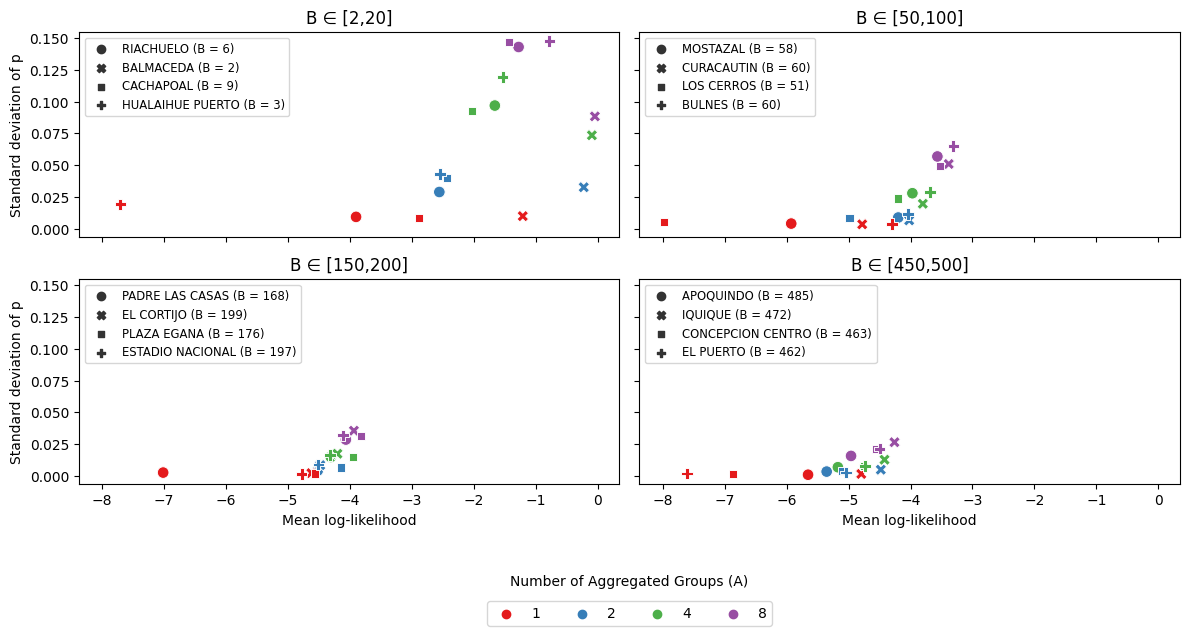

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
GROUP_df_2['G'] = GROUP_df_2['group_combinations'].apply(len)
GROUP_df_2['ll-M'] = GROUP_df_2['ll']/GROUP_df_2['M']
# rango_mesas = [[3,10],[10,50],[50,100],[100,200],[200,300],[400,600]]
GROUP_df_2['Circunscripcion-M'] = GROUP_df_2['Circunscripcion'] + ' ' + GROUP_df_2['M'].astype(str)
GROUP_df_2['District'] = GROUP_df_2['Circunscripcion'].apply(lambda x: x.title())  #.apply(lambda x: x.split(' ')[0])
GROUP_df_2['District_label'] = GROUP_df_2['Circunscripcion'] + ' (B = ' + GROUP_df_2['M'].astype(str) +')'
figure_list = ['s','d','h','v','^']


# Create subplots
fig = plt.figure(figsize=(12, 6))
# fig.suptitle('Figure title')
subfigs = fig.subfigures(nrows = 2, ncols = 1, height_ratios = [24,1])
# sharey = 'row'
ax = subfigs[0].subplots(nrows=2, ncols=2, sharey = True, sharex = True)

# Create an empty list to collect legend handles and labels
legend_handles = []

for i in range(2):
    for j in range(2):
        rango = rango_mesas[i * 2    + j]
        GROUP_circ = GROUP_df_2[(GROUP_df_2['M'] >= rango[0]) & (GROUP_df_2['M'] <= rango[1])]

        # change style to include triangle
        
        # Plot scatter plot and collect legend information
        scatter = sns.scatterplot(data=GROUP_circ, x='ll-M', y='p_std', hue='G', s=70, palette='Set1',
                                  style='District_label', ax=ax[i, j], legend = False)
        sns.scatterplot(data=GROUP_circ, x='ll-M', y='p_std', s=0, 
                                  style='District_label', ax=ax[i, j], legend = True)                           
        ax[i, j].legend(fontsize = 'small', loc = 'upper left')
        ax[i,j].set_title(f'B ∈ [{rango[0]},{rango[1]}]', fontsize = 12)
        # ax[i, j].text(0.5, 0.9, f'B ∈ [{rango[0]},{rango[1]}]', horizontalalignment='center', verticalalignment='center',
        #               transform=ax[i, j].transAxes, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3'))

        # choose x axis label
        ax[i, j].set_xlabel('Mean log-likelihood')
        # choose y label
        ax[i,j].set_ylabel('Standard deviation of p')

        # Collect legend handles and labels from the first subplot
        # if i == 0 and j == 0:
        #     sns.scatterplot(data=GROUP_circ, x='ll-M', y='p_std', s=0, 
        #                     hue='G', palette='Set1', ax=ax[i, j], legend = True)  

        # ax[i, j].get_legend().remove()
#        scatter = sns.scatterplot(data=GROUP_circ, x='ll-M', y='p_std', hue='G', s=70, palette='Set1',
                                 # style='District', ax=ax[i, j], legend = False)

# GROUP_circ.loc[:,'0'] = 0
# GROUP_circ.loc[:,'02'] = 0
axs_label = subfigs[1].subplots(nrows=1, ncols=1)
sns.scatterplot(data=GROUP_circ, x='ll-M', y='p_std', s=0, palette='Set1',
                                 hue='G', ax=axs_label, legend = True)
# set limits
# axs_label.set_xlim([-0.01,0.01])
# axs_label.set_ylim([-0.01,0.01])
axs_label.set_frame_on(False)
axs_label.xaxis.set_visible(False)
axs_label.yaxis.set_visible(False)
axs_label.legend(loc = 'upper center', ncol = 4)
axs_label.set_title('Number of Aggregated Groups (A)', fontsize = 10)


# Create a common legend outside the subplots
# fig.legend(scatter, ['1', '2', '3', '4'], loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=len(labels))

# fig.colorbar(im, ax=ax, shrink = 0.8, pad = .01)
# fig.colorbar(im, shrink = 0.8, pad = .01)

# from matplotlib import colors
# im = plt.scatter([0,0,0,0],[0,0,0,0], c = [1,2,3,4], cmap = 'Set1', s = 0)
# fig.colorbar(im ,ax = ax)
# plt.tight_layout()

plt.tight_layout()
# save with high resolution
plt.savefig('images/elections/group_ll.png', dpi=500, bbox_inches='tight')

plt.show()

AttributeError: 'Legend' object has no attribute 'legend_data'

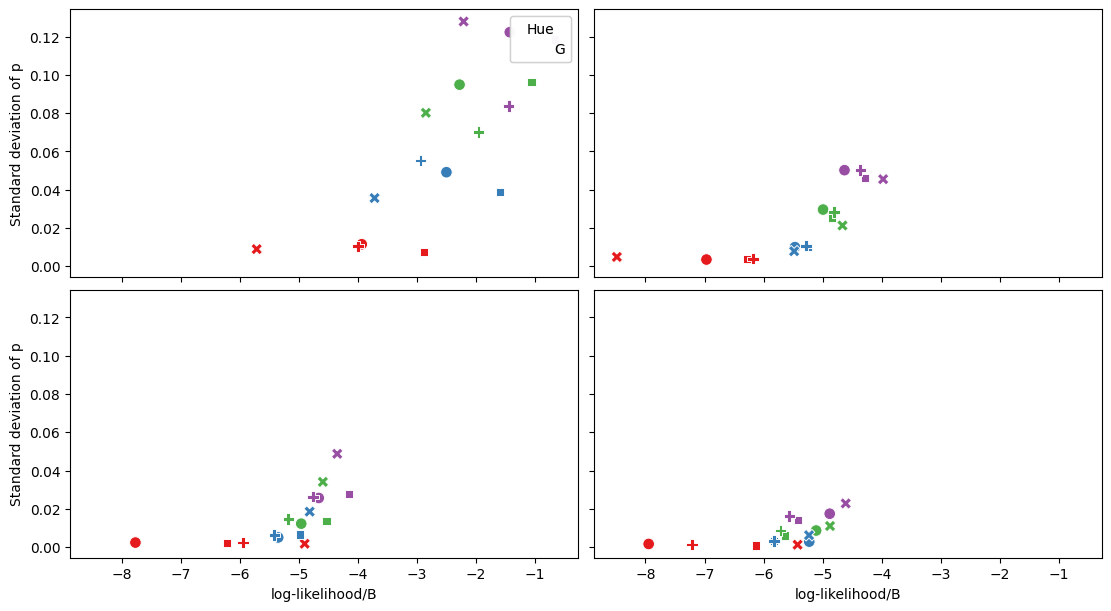

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
GROUP_df_2['G'] = GROUP_df_2['group_combinations'].apply(len)
GROUP_df_2['ll-M'] = GROUP_df_2['ll']/GROUP_df_2['M']
# rango_mesas = [[3,10],[10,50],[50,100],[100,200],[200,300],[400,600]]
GROUP_df_2['Circunscripcion-M'] = GROUP_df_2['Circunscripcion'] + ' ' + GROUP_df_2['M'].astype(str)
GROUP_df_2['District'] = GROUP_df_2['Circunscripcion'].apply(lambda x: x.title())  #.apply(lambda x: x.split(' ')[0])
figure_list = ['s','d','h','v','^']


# Create subplots
fig, ax = plt.subplots(2, 2, figsize=(11, 6), sharey=True, sharex=True, layout='constrained')
# sharey = 'row'

# Create an empty list to collect legend handles and labels
hue_legend = None

for i in range(2):
    for j in range(2):
        rango = rango_mesas[i * 2    + j]
        GROUP_circ = GROUP_df_2[(GROUP_df_2['M'] >= rango[0]) & (GROUP_df_2['M'] <= rango[1])]

        # change style to include triangle
        
        # Plot scatter plot and collect legend information
        scatter = sns.scatterplot(data=GROUP_circ, x='ll-M', y='p_std', hue='G', s=70, palette='Set1',
                                  style='District', ax=ax[i, j])
        
        # Get the legend handles and labels for 'style'
        handles, labels = scatter.get_legend_handles_labels()

        # Add the 'style' legend to the subplot
        style_legend = ax[i,j].legend(handles[1:], labels[1:], title='Style', loc='upper left')

        # Hide the default legend created by Seaborn
        scatter.get_legend().remove()

        # Add the 'hue' legend only once to the figure
        if hue_legend is None:
            hue_legend = scatter.legend(handles[:1], labels[:1], title='Hue', loc='upper right')
            ax[i,j].add_artist(hue_legend)  # Add the 'hue' legend back to the subplot

        # ax[i,j].set_title(f'B ∈ [{rango[0]},{rango[1]}]', fontsize = 12)
        # choose x axis label
        ax[i, j].set_xlabel('log-likelihood/B')
        # choose y label
        ax[i,j].set_ylabel('Standard deviation of p')

        # Collect legend handles and labels from the first subplot
        # if i == 0 and j == 0:
        #     sns.scatterplot(data=GROUP_circ, x='ll-M', y='p_std', s=0, 
        #                     hue='G', palette='Set1', ax=ax[i, j], legend = True)  

        # ax[i, j].get_legend().remove()

# Add the 'hue' legend to the right of the subplots
if hue_legend is not None:
    fig.legend(*hue_legend.legend_data.values(), title='Hue', loc='center left', bbox_to_anchor=(1, 0.5))


plt.show()

## Old

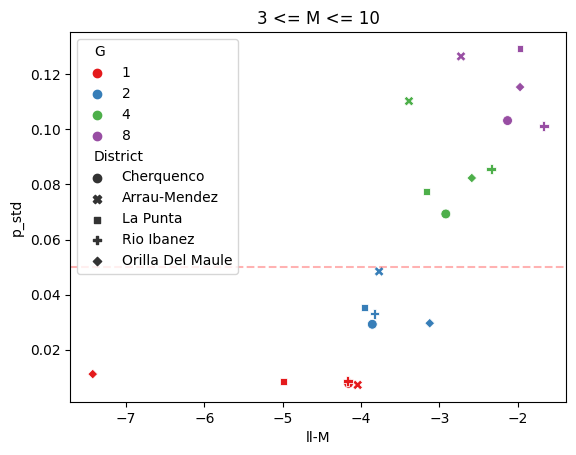

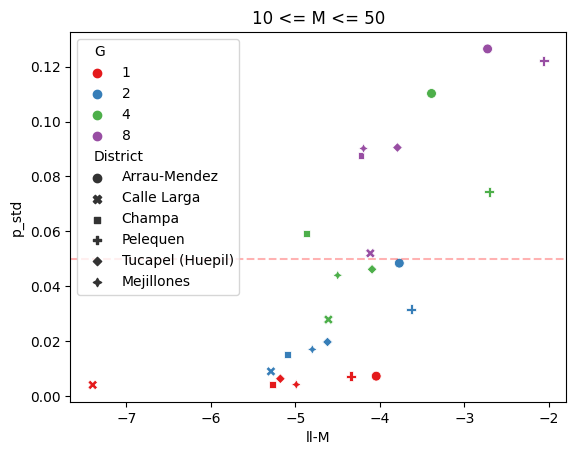

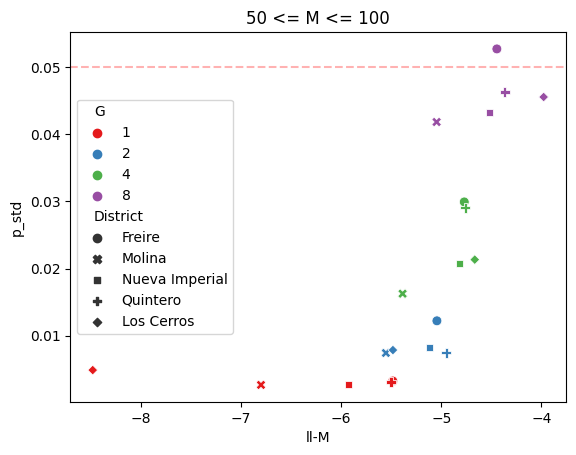

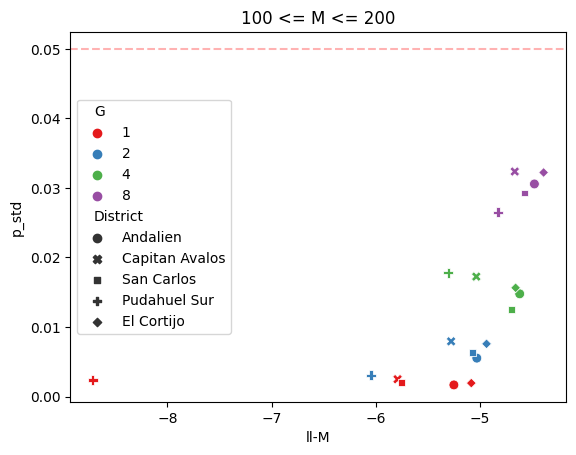

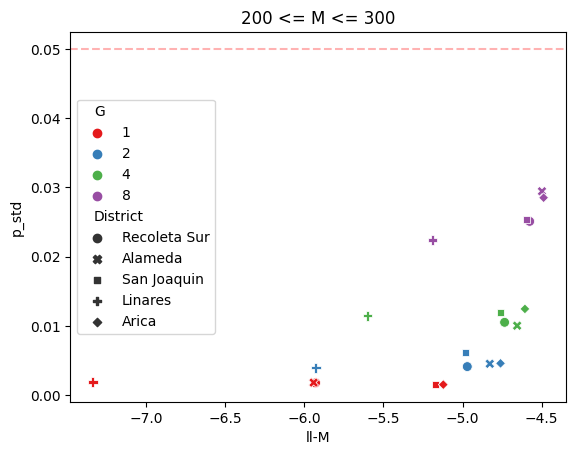

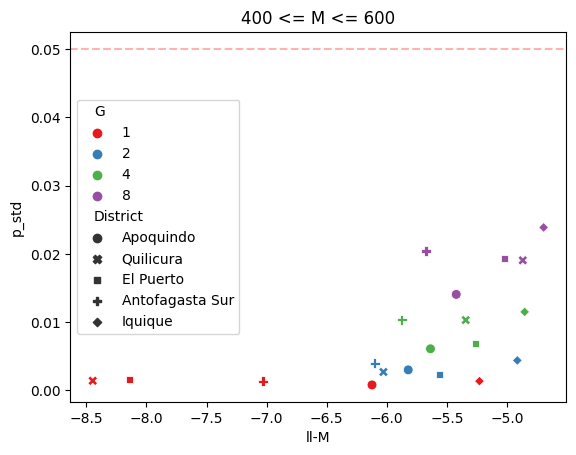

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

GROUP_df['ll-M'] = GROUP_df['ll']/GROUP_df['M']
rango_mesas = [[3,10],[10,50],[50,100],[100,200],[200,300],[400,600]]
GROUP_df['Circunscripcion-M'] = GROUP_df['Circunscripcion'] + ' ' + GROUP_df['M'].astype(str)
GROUP_df['District'] = GROUP_df['Circunscripcion'].apply(lambda x: x.title())  #.apply(lambda x: x.split(' ')[0])
figure_list = ['s','d','h','v','^']

for rango in rango_mesas:
    GROUP_circ = GROUP_df[(GROUP_df['M'] >= rango[0]) & (GROUP_df['M'] <= rango[1])]
    # display(GROUP_circ)
    sns.scatterplot(data = GROUP_circ, x='ll-M', y='p_std', hue = 'G', s= 50, palette = 'Set1',
    style = 'District')
    # set title
    plt.title(f'{rango[0]} <= M <= {rango[1]}')
    # draw horizontal line at 0.05
    plt.axhline(y=0.05, color='r', linestyle='--', alpha = 0.3)
    
    plt.show()
        # display(MIP_circ.loc[[MIP_circ['ll'].idxmax()]])

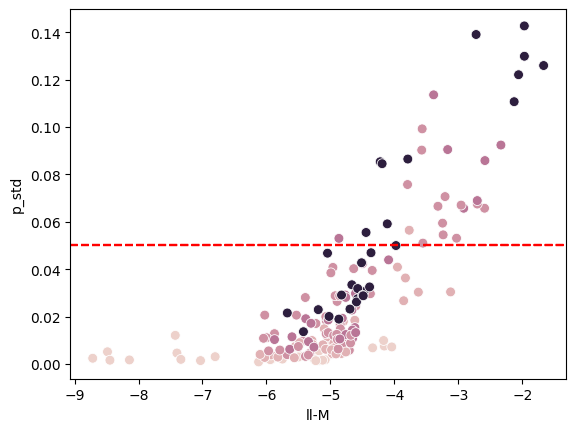

In [17]:

MIP_df['ll-M'] = MIP_df['ll']/MIP_df['M']


for circ_M in circs:
    for i, circ in enumerate(circ_M):
        MIP_circ = MIP_df[(MIP_df['Circunscripcion'] == circ)]
        # display(MIP_circ)
        sns.scatterplot(data = MIP_circ, x='ll-M', y='p_std', hue = 'n groups', s= 50, legend = False)
    # draw horizontal line at 0.05
    plt.axhline(y=0.05, color='r', linestyle='--', alpha = 0.8)
    
plt.show()
        # display(MIP_circ.loc[[MIP_circ['ll'].idxmax()]])